2020년 11월 30일  ver.

table of contents <br>
[1. 필요한 파일 불러오기 및 정리](#bullet1)<br>
[2. 데이터 EDA](#bullet2)<br>
[3. Prediction With Surprise](#bullet3)<br>

# 필요한 파일 불러오기 및 정리<a class="anchor" id="bullet1"></a>


In [21]:
from scipy.stats import pearsonr
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
all_review = pd.read_csv('data/댓글합.csv',index_col = 0)
all_review.drop_duplicates(inplace=True)
all_review.sample()

,nickname,rating,title,voice,author,review,created,publish,genre
7190,catnap,100,당신의 슬픔을 훔칠게요,김현,김현,잘 들었어요,2020.10.02,미디어창비,소설문학


In [3]:
all_book = pd.read_csv('data/전체합.csv', index_col = 0)
all_book.sample()

,title,voice,author,publish,genre
950,왕의 재정 2,신송이,김미진,규장,인문교양


In [25]:
all_review['rating'] = all_review['rating'].apply(lambda x : x/10)
all_review.sample()

,nickname,rating,title,voice,author,review,created,publish,genre,read_by
9322,boomboomsu,8.0,최민식이 읽는 이범선의 오발탄,최민식,이범선,기획이 너무참신하고 좋네요,2018.12.24,커뮤니케이션북스,오디오북스,celeb


## title_df, user_df 만들기<a class="anchor" id="bullet1.1"></a>

In [13]:
# user_df = pd.DataFrame(list(df.nickname	.unique()), columns = ['nickname'])
# user_df['usr_id'] = random.sample(range(1,len(user_df)+1), len(user_df))

# title_df = pd.DataFrame(list(df.title.unique()), columns = ['title'])
# title_df['ttl_id'] = random.sample(range(1,len(title_df)+1), len(title_df))

# df = df.merge(user_df, how = 'left' )
# df = df.merge(title_df, how = 'left' )
# df.columns = ['user', 'title', 'rating', 'usr_id', 'ttl_id']
# df.sample()

In [14]:
# pivot_df = df.pivot_table('rating', index = 'user', columns = 'title')
# pivot_df.sample(4)

# 데이터 EDA<a class="anchor" id="bullet2"></a>

[현진] **장르의 평점 많은 순 정렬, (평점 개수와 함께) 평점 높은 순 정렬**<br>
[현진] **팟빵 오디오북 유저들의 장르 취향 파악: 한 우물형 vs 포도송이형**<br>
[한나] **별점의 분포가 넓은 유저들의 특징과 리뷰를 많이 작성하는 유저들의 별점 분포**<br>
**기간에 따른 리뷰 댓글 수 차이 비교 (시계열 분석**<br>
[한나] **책 내용을 녹음한 목소리의 주인이 누구인지에 따라 평점 수, 평균 비교**<br>

## 유명인이 읽어주는 경우 vs 작가가 읽어주는 경우 vs 일반성우

**null값을 찾자**

In [4]:
print(f"전체 책 수는 : {len(all_book.title.unique())}")

전체 책 수는 : 1719


작가가 없는 책 찾기

In [5]:
all_book[all_book['author'].isnull()].title.unique()

array(['우리나라 삼국지 5권', '[김동식 단편] 흐르는 물이 되어', '100인의 배우, 우리 문학을 읽다'],
      dtype=object)

**왜 작가가 없을까**<br>
1) 우리나라 삼국지 5권: 저자 - 임동주. 시리즈 1-4권 까지는 임동주로 나와있음. <br>
2) 흐르는 물이 되어: 작가 - 김동식. <br>
1,2번은 오류로 빠진듯. 데이터에 추가해야 함 <br>

3) 100인의 배우, 우리 문학을 읽다: 여러 책을 함께 담은 시리즈이기 때문에 한 명의 작가는 없음 <br>
[100인 책 페이지](http://m.podbbang.com/audiobook/channel?id=1769055)를 들어가보면 목차 안으로 들어가야 각 책의 제목, 목소리, 작가를 알 수 있음 <br>
그런데 이 목차 안의 콘텐츠를 따로 빼서 제공하는 중이기도 함

In [6]:
all_book[all_book['author'].isnull()].title.unique()

array(['우리나라 삼국지 5권', '[김동식 단편] 흐르는 물이 되어', '100인의 배우, 우리 문학을 읽다'],
      dtype=object)

In [7]:
all_book[all_book['title'].isin(['우리나라 삼국지 5권', '[김동식 단편] 흐르는 물이 되어'])]

,title,voice,author,publish,genre
171,우리나라 삼국지 5권,NaN,NaN,임동주,소설문학
455,[김동식 단편] 흐르는 물이 되어,이준우,NaN,김동식,소설문학


In [8]:
all_book.iloc[171, 3] = "임동주"
all_book.iloc[455, 3] = "김동식"

In [9]:
all_book[all_book['title'].isin(['우리나라 삼국지 5권', '[김동식 단편] 흐르는 물이 되어'])]

,title,voice,author,publish,genre
171,우리나라 삼국지 5권,NaN,NaN,임동주,소설문학
455,[김동식 단편] 흐르는 물이 되어,이준우,NaN,김동식,소설문학


목소리가 잘 들어간 걸 볼 수 있다!

다시 3번으로 돌아와서, 100권 시리즈 외에 한 권씩 따로 서비스 하는 중인지 확인해봤음

In [21]:
all_book[all_book['title'].str.contains('원미동')]

,title,voice,author,publish,genre
724,길해연이 읽는 양귀자의 원미동 시인,길해연,양귀자,커뮤니케이션북스,오디오북스


그러면 이 오디오북 시리즈에 대한 리뷰 따로, 특정 책에 대한 리뷰는 따로 해야할 듯

**voice가 없는 책 찾기**

In [10]:
print(f"전체 책 수는 : {len(all_book.title.unique())}")
print(f"voice가 없는 책 수는 : {len(all_book[all_book['voice'].isnull()].title.unique())}")

전체 책 수는 : 1719
voice가 없는 책 수는 : 846


<div class="alert alert-warning">
기계가 녹음한 경우 voice가 없을 수 있는데 과연 그게 다일지는 모르겠음 <br>
어떻게 우리가 확인할 수 있을까? -> 일단 나중에 고민하고 우선은 Nan == 기계음 으로 생각하자
</div>

**voice tag를 구분하자!**

In [23]:
all_book.sample()

,title,voice,author,publish,genre
1253,"저듸, 곰새기",NaN,장수진,아이들은자연이다,어린이동화


In [11]:
titles = all_book.title.unique() #모든 책 제목을 titles 리스트에 담아서 아래와 같이 구분

In [12]:
read_by_none = all_book[all_book['voice'].isnull()].title.unique()
read_by_author = list(all_book.query('voice == author').title.unique())
read_by_celeb = [title for title in titles if ("낭독" in title) or ("읽는" in title) or ("배우" in title)]
read_by_someone = [title for title in titles if title not in read_by_celeb and title not in read_by_author and title not in read_by_none]

In [13]:
all_book['read_by'] = ""

all_book['read_by'] = all_book['title'].apply(lambda x : "celeb" if x in read_by_celeb else ("author" if x in read_by_author else ("someone" if x in read_by_someone else "robot")))

all_book.sample(5)

,title,voice,author,publish,genre,read_by
177,[이성종 낭독] 바람의 독서법 (단편),이성종 (인피니트),김선영,자음과 모음,소설문학,celeb
714,[세계환상문학선] 만리장성을 쌓을 때,박창순,프란츠 카프카,커뮤니케이션북스 & 바다출판사,오디오북스,someone
225,[한예리 낭독] 안락 _ 작은책,한예리,은모든,아르테,소설문학,celeb
215,위대한 유산(요약본),김은정,찰스디킨스,북코스모스,소설문학,someone
785,박웅이 읽는 유진오의 창랑정기,박웅,유진오,커뮤니케이션북스,오디오북스,celeb


### 목소리별 책 수

In [82]:
all_book.groupby('read_by')['title'].count().to_frame().reset_index()


,read_by,title
0,author,265
1,celeb,189
2,robot,842
3,someone,425


### 목소리별 평점 분포

In [14]:
all_book.sample()

,title,voice,author,publish,genre,read_by
1176,운명을 바꾼 가믄장아기,NaN,이상교,국민서관(주),어린이동화,robot


In [26]:
review_by_voice = all_review.merge(all_book[['title', 'read_by']], how='left').pivot_table(index = "nickname", columns = 'read_by', values = "rating", aggfunc = "mean")
review_by_voice.sample()

read_by,author,celeb,robot,someone
nickname,,,,
수제로로,10.0,NaN,NaN,NaN


In [27]:
all_review[all_review['title'].isin(read_by_author)].rating.describe()

count    2007.000000
mean        9.789736
std         0.835190
min         1.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64

In [28]:
all_review[all_review['title'].isin(read_by_celeb)].rating.describe()

count    4273.000000
mean        9.385912
std         1.227097
min         1.000000
25%         9.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64

In [29]:
all_review[all_review['title'].isin(read_by_someone)].rating.describe()

count    6967.000000
mean        9.497775
std         1.212418
min         1.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64

In [30]:
all_review[all_review['title'].isin(read_by_none)].rating.describe()

count    2283.000000
mean        9.375821
std         1.235174
min         1.000000
25%         9.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64

In [17]:
all_review[all_review.author.isnull()].title.unique()

array(['100인의 배우, 우리 문학을 읽다'], dtype=object)

In [31]:
all_review = all_review.merge(all_book[['title', 'read_by']], how='left')

In [48]:
all_review.sample()

,nickname,rating,title,voice,author,review,created,publish,genre,read_by
5334,소잃고뇌약간고치다,10.0,[공포괴담집] 저승에서 돌아온 남자,왓섭,문화류씨,오...이거 재미나겠네요 나중에라도 구매해서 들어봐야겠네요,2019.07.12,요다,소설문학,someone


In [103]:
review_count_read_by = all_review.pivot_table(index = "rating", columns = "read_by", values = "review", aggfunc = "count")
review_count_read_by.replace(np.NaN, 0, inplace=True)

In [110]:
review_count_read_by['author_%'] = round(review_count_read_by['author'] / review_count_read_by['author'].sum(),3)*100

review_count_read_by['celeb_%'] = round(review_count_read_by['celeb'] / review_count_read_by['celeb'].sum(),3)*100

review_count_read_by['robot_%'] = round(review_count_read_by['robot'] / review_count_read_by['robot'].sum(),3)*100

review_count_read_by['someone_%'] = round(review_count_read_by['someone'] / review_count_read_by['someone'].sum(), 3)*100

In [111]:
review_count_read_by

read_by,author,celeb,robot,someone,author_%,celeb_%,robot_%,someone_%
rating,,,,,,,,
1.0,5.0,5.0,9.0,44.0,0.2,0.1,0.4,0.6
2.0,2.0,17.0,6.0,12.0,0.1,0.4,0.3,0.2
3.0,0.0,2.0,5.0,7.0,0.0,0.0,0.2,0.1
4.0,2.0,16.0,5.0,15.0,0.1,0.4,0.2,0.2
5.0,7.0,10.0,9.0,29.0,0.3,0.2,0.4,0.4
6.0,12.0,131.0,39.0,109.0,0.6,3.1,1.7,1.6
7.0,17.0,83.0,66.0,149.0,0.8,2.0,2.9,2.1
8.0,74.0,615.0,278.0,586.0,3.7,14.5,12.2,8.4
9.0,67.0,260.0,274.0,678.0,3.3,6.1,12.0,9.7


- celeb이 읽은 책에 대한 평점의 14%가 8점
- 작가가 읽어준 경우가 10점 비중이 가장 높은데 이게 정말 컨텐츠가 좋아서일까?
- 연예인/기계가 읽은 경우의 평점이 가장 다양하게 분포

### 목소리별 평점 분포 시각화

Text(0.5, 1.0, '유명인이 읽어준 책에 대한 평점 분포')

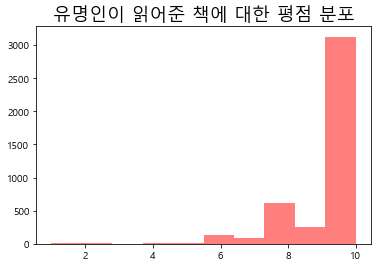

In [33]:
plt.hist(all_review.query('read_by == "celeb"')['rating'], alpha = 0.5, color = "r")
plt.title("유명인이 읽어준 책에 대한 평점 분포", fontsize=18)

Text(0.5, 1.0, '작가가 읽어준 책에 대한 평점 분포')

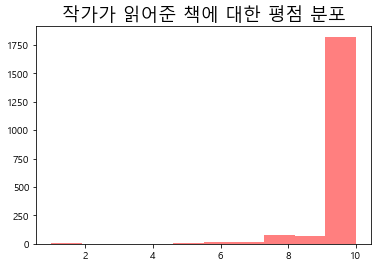

In [34]:
plt.hist(all_review.query('read_by == "author"')['rating'], alpha = 0.5, color = "r")
plt.title("작가가 읽어준 책에 대한 평점 분포", fontsize=18)

Text(0.5, 1.0, '비연예인/비작가/비기계가 읽어준 책에 대한 평점 분포')

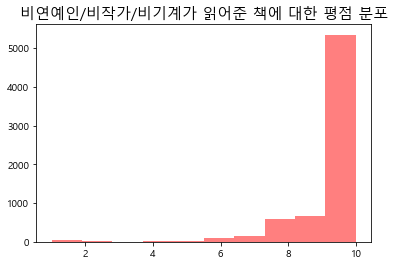

In [72]:
plt.hist(all_review.query('read_by == "someone"')['rating'], alpha = 0.5, color = "r")
plt.title("비연예인/비작가/비기계가 읽어준 책에 대한 평점 분포", fontsize=15)

Text(0.5, 1.0, '기계가 읽어준 책에 대한 평점 분포')

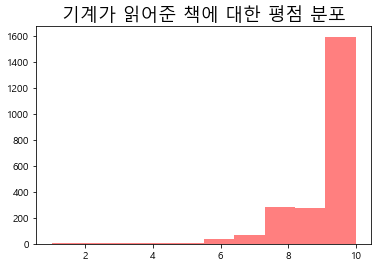

In [36]:
plt.hist(all_review.query('read_by == "robot"')['rating'], alpha = 0.5, color = "r")
plt.title("기계가 읽어준 책에 대한 평점 분포", fontsize=18)

(array([  10.,    6.,    5.,    5.,    9.,   39.,   66.,  279.,  276.,
        1594.]),
 array([ 10.,  19.,  28.,  37.,  46.,  55.,  64.,  73.,  82.,  91., 100.]),
 <BarContainer object of 10 artists>)

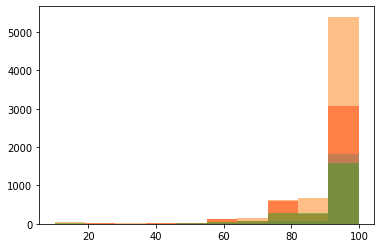

In [285]:
# 따로 그리고 싶다.. 그러나 한 셀 안에..
plt.hist(all_review.query('read_by == "celeb"')['rating'], alpha = 0.5, color = "r")
plt.hist(all_review.query('read_by == "author"')['rating'], alpha = 0.5)
plt.hist(all_review.query('read_by == "someone"')['rating'], alpha = 0.5)
plt.hist(all_review.query('read_by == "robot"')['rating'], alpha = 0.5)

### 목소리별 평점 회귀분석

In [37]:
from statsmodels.formula.api import ols

In [38]:
ols('rating ~ read_by', data = all_review).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     61.48
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           1.66e-39
Time:                        20:52:22   Log-Likelihood:                -24600.
No. Observations:               15534   AIC:                         4.921e+04
Df Residuals:                   15530   BIC:                         4.924e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.7897      0.026    371.931      0.000       9.738       9.841
read_by[T.celeb]      -0.4038      0.032    -12.655      0.000      -0.466      -0.341
read_by[T.robot]      -0.4139      0.036    -11.472      0.000      -0.485      -0.343
read_by[T.someone]    -0.2931      0.030     -9.812      0.000      -0.352      -0.235
==============================================================================
Omnibus:                    11522.735   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           206333.499
Skew:                          -3.481   Prob(JB):                         0.00
Kurtosis:                      19.441   Cond. No.                         6.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

일반적으로 작가가 읽었을 때 가장 평점이 높음<br>
근데 r제곱이 1퍼센트..^^

## 전체 평점 분포

위의 회귀분석 결과에 따르면 읽어주는 목소리에 따른 점수 차이는 최대 0.4점<br>
그러나 우리 데이터의 분포를 생각할 때 0.4점 차이도 크다고 할 수 있음

In [40]:
for_plot = all_review['rating'].quantile(np.arange(0, 1, 0.025)).to_frame().reset_index()

for_plot.columns = ['percentage', 'rating_value']

for_plot['percentage'] = for_plot['percentage'].apply(lambda x : round(x, 3)).apply(str)

Text(0.5, 1.0, '평점 분포 (1/4분위까지)')

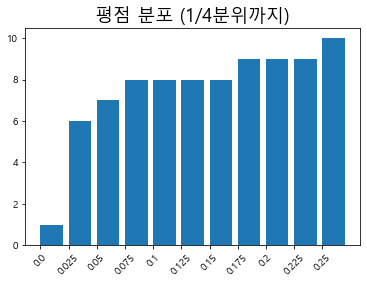

In [42]:
plt.bar(for_plot.iloc[:11, :]['percentage'], for_plot.iloc[:11, :]['rating_value'], align = 'edge')
plt.xticks(rotation = 45)
plt.title("평점 분포 (1/4분위까지)", fontsize = 18)

Text(0.5, 1.0, '평점 분포 (전체)')

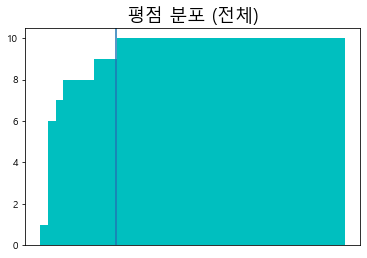

In [46]:
plt.bar(for_plot['percentage'], for_plot['rating_value'], align = 'edge',color = "c", width = 1)
plt.axvline(x=9.9)
plt.xticks([])
plt.title("평점 분포 (전체)", fontsize = 18)

## 리뷰 길이

In [80]:
with_review = all_review.dropna(how = 'any',subset=["review"], axis = 0) #rating만 있는 경우 drop

In [81]:
with_review["length"] = with_review['review'].apply(len)
with_review.sample()

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,nickname,rating,title,voice,author,review,created,publish,genre,read_by,length
2100,단밭빵퉷,80,담배만이 우리 세상,남도형,류연웅,학창시절 생각나네요 \r\n재밌게 잘들었습니다.,2019.09.29,안전가옥,소설문학,someone,24


In [142]:
with_review[(with_review['review'].str.contains('들었습니다')) & (with_review['length'] < 10)].review.unique()[:3] #세개만 샘플로 뽑아봤어요

array(['잘들었습니다.', '잘들었습니다', '잘 들었습니다'], dtype=object)

## 유저별 평점 variance 

In [50]:
review_per_user = all_review.groupby(['nickname', 'title'])['rating'].first().to_frame().reset_index()
review_per_user.sample()

,nickname,title,rating
11776,웅크린냥이,인간에 대한 예의,10.0


책 한권에 대한 리뷰만 남긴 유저는 제외하고 분산을 살펴보려 함

In [52]:
review_count = review_per_user.groupby('nickname')['rating'].count().to_frame()
review_one = list(review_count.query('rating == 1').index)

In [53]:
review_var = review_per_user[~review_per_user['nickname'].isin(review_one)].groupby('nickname')['rating'].var(ddof = 0).to_frame()
review_var.columns = ['rating_variance']
review_var.sample()

,rating_variance
nickname,
legacykh,0.25


In [54]:
review_var[review_var['rating_variance'].isnull()].shape[0]

0

In [55]:
review_var.query('nickname == "amartia"')

,rating_variance
nickname,
amartia,0.25


In [56]:
review_per_user.query('nickname == "amartia"')

,nickname,title,rating
954,amartia,모두 거짓말을 한다,8.0
955,amartia,아몬드,9.0


In [57]:
review_var.sample(3)

,rating_variance
nickname,
벙직,0.000000
2018YBM,0.250000
이좃까야,0.052469


In [58]:
np.var(review_per_user.query("nickname == 'djsjsjss'")['rating'])

6.6942148760330555

### 유저당 평점 분산 시각화

Text(0.5, 1.0, '유저당 평점 분산')

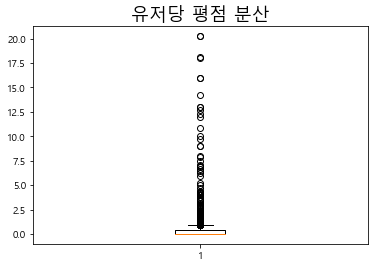

In [62]:
plt.boxplot(review_var)
plt.title("유저당 평점 분산",fontsize=18)

Text(0.5, 1.0, '유저당 평점 분산 (아웃라이어 제외)')

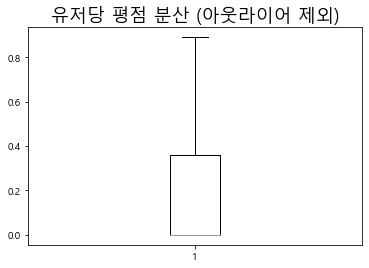

In [63]:
plt.boxplot(review_var, showfliers=False)
plt.title("유저당 평점 분산 (아웃라이어 제외)",fontsize=18)

### heavy user의 평점 분산

In [64]:
review_var_count = review_var.merge(review_count, left_index = True, right_index = True)
review_var_count.columns = ['rating_variance', 'rating_count']
review_var_count.sample()

,rating_variance,rating_count
nickname,,
슬로우볼,0.0,14


In [113]:
review_count.describe()

,rating
count,4450.000000
mean,3.489213
std,6.100897
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,65.000000


In [114]:
review_count.quantile(np.arange(0.75, 1, 0.05))

,rating
0.75,3.0
0.80,4.0
0.85,5.0
0.90,9.0
0.95,16.0


In [116]:
review_count.quantile(np.arange(0.9, 1, 0.025))

,rating
0.900,9.000
0.925,12.000
0.950,16.000
0.975,21.775


Text(0.5, 1.0, 'Heavy User의 유저당 평점 분산 (Flier 포함)')

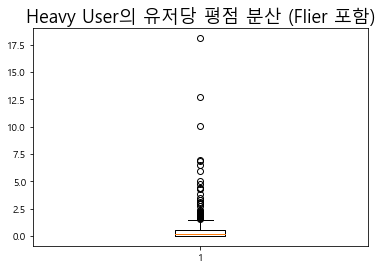

In [119]:
for_plot = review_var_count[review_var_count['rating_count'] >= 12]['rating_variance']
plt.boxplot(for_plot)
plt.title("Heavy User의 유저당 평점 분산 (Flier 포함)",fontsize=18)

Text(0.5, 1.0, 'Heavy User의 유저당 평점 분산 (Flier 제외)')

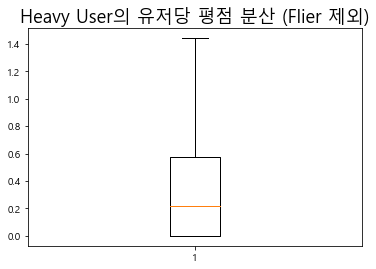

In [120]:
for_plot = review_var_count[review_var_count['rating_count'] >= 12]['rating_variance']
plt.boxplot(for_plot, showfliers=False)
plt.title("Heavy User의 유저당 평점 분산 (Flier 제외)",fontsize=18)

### 별점 분포가 넓은 유저들의 특징

In [130]:
review_var_count['rating_variance'].describe()

count    1646.000000
mean        0.527955
std         1.652693
min         0.000000
25%         0.000000
50%         0.000000
75%         0.359844
max        20.250000
Name: rating_variance, dtype: float64

In [132]:
review_var_count['rating_variance'].quantile(np.arange(0.75, 1, 0.05))

0.75    0.359844
0.80    0.634615
0.85    0.888889
0.90    1.018988
0.95    2.250000
Name: rating_variance, dtype: float64

In [139]:
var_over_2 = list(review_var_count[review_var_count['rating_variance'] >= 2].index)

평점 분산이 2 이상인 user들만 모아서 리스트로 만들었음

In [149]:
review_var_count.loc[var_over_2].rating_count.describe()

count    97.000000
mean     10.855670
std      12.792405
min       2.000000
25%       2.000000
50%       5.000000
75%      13.000000
max      54.000000
Name: rating_count, dtype: float64

Text(0.5, 1.0, '평점 분산이 2 이상의 유저의 평가 횟수')

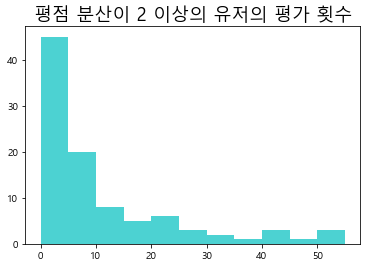

In [171]:
plt.hist(review_var_count.loc[var_over_2].rating_count, bins = np.arange(0,60,5), color = 'c', alpha = 0.7)
plt.title('평점 분산이 2 이상의 유저의 평가 횟수', fontsize=18)

In [186]:
df = all_review[all_review['nickname'].isin(var_over_2)].pivot_table(index='nickname', columns = 'genre', values ='title', aggfunc = 'count')

In [188]:
# df.replace(np.NaN, 0, inplace=True)
df.sample()

genre,경제경영,소설문학,어린이동화,오디오북스,인문교양,자기계발
nickname,,,,,,
새벽3,NaN,4.0,NaN,NaN,NaN,NaN


In [252]:
df1 = all_review[all_review['nickname'].isin(var_over_2)][['nickname', 'review']]
df1['review_length'] = df1['review'].apply(str).apply(lambda x :len(x))
df1 = df1.groupby('nickname')['review_length'].mean().to_frame()
df1.sample()

,review_length
nickname,
고두림,6.0


In [253]:
df1.review_length.describe()

count     97.000000
mean      21.401105
std       27.124205
min        2.000000
25%        6.000000
50%       12.142857
75%       25.333333
max      167.000000
Name: review_length, dtype: float64

In [254]:
df2 = all_review[['nickname', 'review']]
df2['review_length'] = df2['review'].apply(str).apply(lambda x :len(x))
df2 = df2.groupby('nickname')['review_length'].mean().to_frame()
df2.review_length.describe()

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



count    4450.000000
mean       19.444578
std        28.390729
min         1.000000
25%         6.000000
50%        11.225000
75%        21.000000
max       590.000000
Name: review_length, dtype: float64

Text(0.5, 1.0, '평점 분산이 2 이상인 유저들의 평균 댓글 길이')

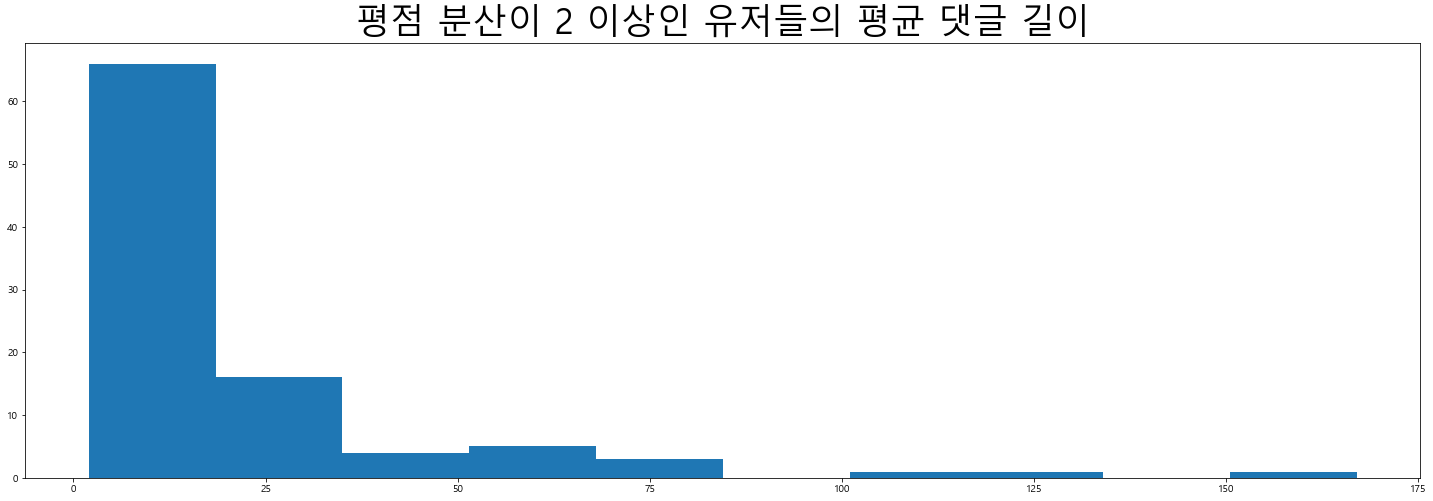

In [258]:
plt.figure(figsize = (25, 8))
plt.hist(df1.review_length)
plt.title("평점 분산이 2 이상인 유저들의 평균 댓글 길이", fontsize = 35)

Text(0.5, 1.0, '모든 유저들의 평균 댓글 길이')

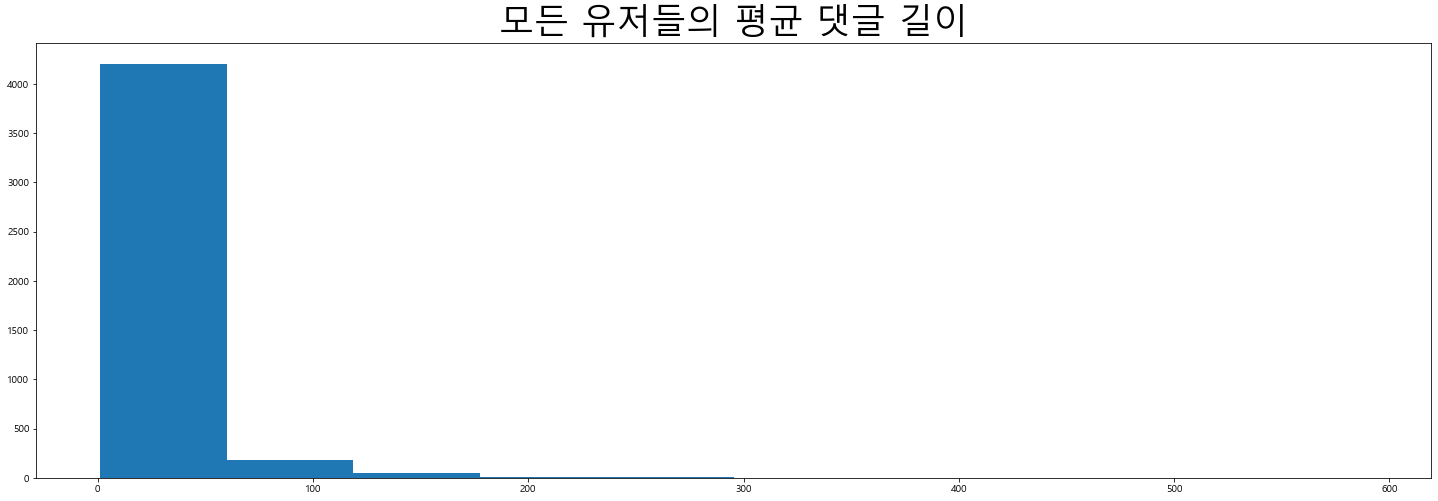

In [259]:
plt.figure(figsize = (25, 8))
plt.hist(df2.review_length)
plt.title("모든 유저들의 평균 댓글 길이", fontsize = 35)

분산이 클 수록 평균 댓글 길이가 길 줄 알았는데 그건 아님

이 이상으론 텍스트분석 필요

## general EDA

In [330]:
print(f"리뷰데이터의 크기는             : {all_review.shape}")
print(f"리뷰데이터에 포함된 유저의 수는 : {len(all_review['nickname'].unique())} 명")
print(f"리뷰데이터에 포함된 책의 수는   : {len(all_review['title'].unique())} 권")

리뷰데이터의 크기는             : (15533, 11)
리뷰데이터에 포함된 유저의 수는 : 4450 명
리뷰데이터에 포함된 책의 수는   : 195 권


In [122]:
sns.countplot?

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

FixedFormatter should only be used together with FixedLocator



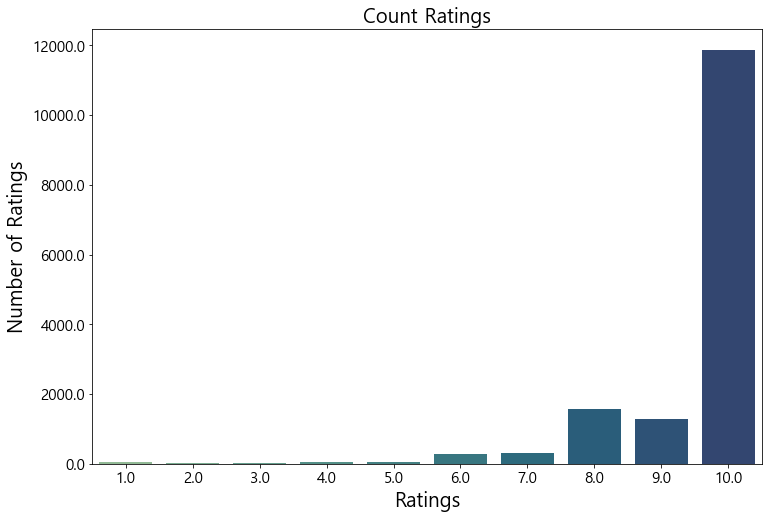

In [127]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=all_review, palette = 'crest')
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

일단 가장 높은 n개의 값만 보여주는 함수를 만듭니다.

In [336]:
def return_best_n(statistics, n):
    # statistics: array of size review.shape[1] containing one statistic calculated from the dataset
    # n: number of indices to be returned
    # returns: array of size *n* containing the indices of the best scored statistics
    statistics = pd.DataFrame({'statistic':statistics})
    return statistics.sort_values('statistic', ascending = False).iloc[:n]

### Mean Rating <a class="anchor" id="bullet2.1"></a>


In [337]:
means = all_review.pivot_table(columns='title', index = 'nickname', values = 'rating').iloc[:,2:].apply(np.mean)
return_best_n(means,10)

,statistic
title,
"달려라, 아비",100.0
[와우 낭독] 지금 아니면 못 할 일 (단편),100.0
이원승이 읽는 현진건의 운수 좋은 날,100.0
김의성이 읽는 최인호의 타인의 방,100.0
김용 대하역사무협 신조협려 하이라이트,100.0
김영민이 읽는 현경준의 탁류,100.0
길해연이 읽는 양귀자의 원미동 시인,100.0
기주봉이 읽는 하근찬의 수난이대,100.0
공룡 이야기 마을_고집 센 벨로키랍토르(영어),100.0


### Rating Count<a class="anchor" id="bullet2.2"></a>


In [223]:
count = all_review.pivot_table(columns='title', index = 'nickname', values = 'rating').iloc[:,2:].apply(lambda col : np.sum(~np.isnan(col)))

# return_best_n(count,10).index 를 구하면 제목만 뽑을 수 있음
return_best_n(count,10)

NameError: name 'return_best_n' is not defined

In [222]:
count

NameError: name 'count' is not defined

평균 평점 top10의 책은 몇개의 리뷰가 있을까?

In [339]:
top10_avg_ratings = return_best_n(means,10).index
count.loc[top10_avg_ratings]

title
달려라, 아비                      1
[와우 낭독] 지금 아니면 못 할 일 (단편)    1
이원승이 읽는 현진건의 운수 좋은 날         2
김의성이 읽는 최인호의 타인의 방           5
김용 대하역사무협 신조협려 하이라이트         2
김영민이 읽는 현경준의 탁류              1
길해연이 읽는 양귀자의 원미동 시인          1
기주봉이 읽는 하근찬의 수난이대            1
공룡 이야기 마을_고집 센 벨로키랍토르(영어)    1
강신일이 읽는 최서해의 탈출기             1
dtype: int64

### Percentage of Good Ratings<a class="anchor" id="bullet2.3"></a>


In [340]:
good_count = all_review.pivot_table(columns='title', index = 'nickname', values = 'rating').iloc[:,2:].apply(lambda col : np.sum(col >=  80)/np.sum(~np.isnan(col)))
return_best_n(good_count,3)

,statistic
title,
<테이크아웃 오디오북> 목견,1.0
눈물을 자르는 눈꺼풀처럼(시 10편),1.0
신경 끄기의 기술 (완독),1.0


In [13]:
#위 코드 이해하기
col = pivot_df.iloc[:,2:]['나는 왠지 대박날 것만 같아!']
print(np.sum(col >= 80))
print(np.sum(~np.isnan(col)))

387
391


애초에 리뷰가 한개인 경우는 리뷰 수 대비 좋은 리뷰 값이 1로 나옴<br>
이걸 해결하기 위해서 리뷰 숫자가 충분한 경우만 확인

In [341]:
means = pd.DataFrame(means, columns = ['rating_avg'])
count = pd.DataFrame(count, columns = ['no_of_ratings'])
rating_pct = pd.DataFrame(good_count, columns = ['over_80_ratio'])

ratings = pd.merge(left=means, right=count, how='left',left_index=True,right_index=True)

ratings = ratings.merge(rating_pct, how='left',left_index=True,right_index=True)

ratings.sample(3)

,rating_avg,no_of_ratings,over_80_ratio
title,,,
[김병관 낭독] 못 먹어도 go! (단편),100.000000,1,1.000000
남편을 죽이는 서른 가지 방법,55.000000,2,0.500000
[세계환상문학선] 아서 새빌 경의 범죄,89.142857,35,0.885714


In [342]:
ratings.query('no_of_ratings > 100').sort_values(by='over_80_ratio', ascending=False).head(3)

,rating_avg,no_of_ratings,over_80_ratio
title,,,
오만과 편견(요약본),99.339623,106,1.000000
열하일기 첫걸음,99.545455,352,0.997159
세계는 왜 싸우는가,99.171975,314,0.996815


<AxesSubplot:>

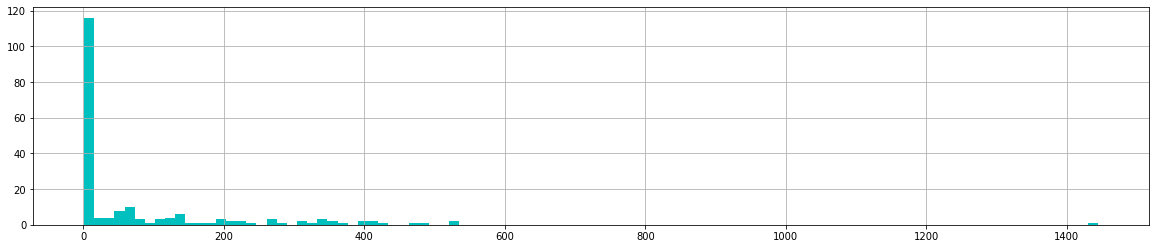

In [343]:
plt.figure(figsize = (20,4))
ratings['no_of_ratings'].hist(bins=100,color='c')

<AxesSubplot:>

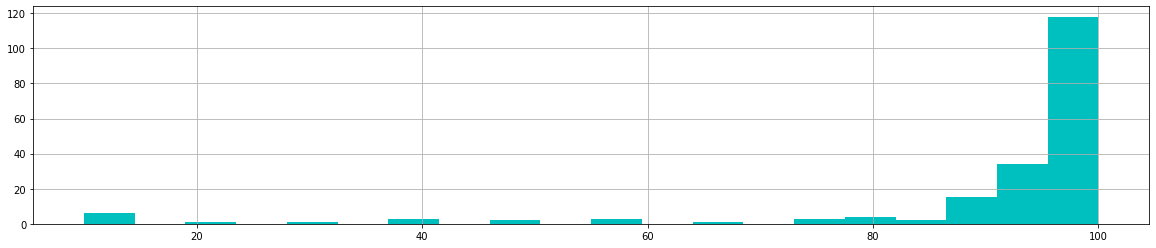

In [344]:
plt.figure(figsize = (20,4))
ratings['rating_avg'].hist(bins=20,color='c')

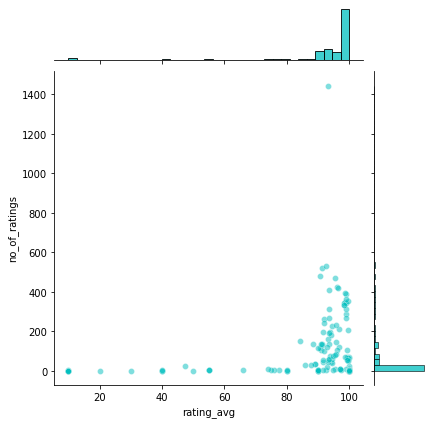

In [345]:
sns.jointplot(x='rating_avg', y='no_of_ratings', data= ratings, alpha = 0.5, color='c')

<div class="alert alert-warning">
분석에서 아래와 같이 rating이 몇개 이상인 책만 뽑아서 봐도 되는것...?
</div>

In [346]:
ratings['no_of_ratings'].describe()

count     193.000000
mean       79.528497
std       157.730190
min         1.000000
25%         1.000000
50%         4.000000
75%        86.000000
max      1445.000000
Name: no_of_ratings, dtype: float64

하위 50%의 분포를 살펴보면: 1~4정도임

In [347]:
ratings['no_of_ratings'].quantile(np.arange(0, 0.5, 0.05))

0.00    1.0
0.05    1.0
0.10    1.0
0.15    1.0
0.20    1.0
0.25    1.0
0.30    1.0
0.35    2.0
0.40    2.0
0.45    2.0
Name: no_of_ratings, dtype: float64

그렇다면 평가를 n개 이하 했던 inactive user 에 대해서도?

In [348]:
count_user_rating = all_review.pivot_table(index='title', columns = 'nickname', values = 'rating').iloc[:,2:].apply(lambda col : np.sum(~np.isnan(col)))

# return_best_n(count,10).index 를 구하면 제목만 뽑을 수 있음
return_best_n(count_user_rating,10)

,statistic
nickname,
마임,65
대룡리말바위,54
고트프리트,52
swagger,51
kwonjkim,47
코끼리311,46
initialj,46
미다진구,46
던힐발란스,45


In [354]:
count_user_rating = pd.DataFrame(count_user_rating)
count_user_rating.columns = ['user_rating_cnt']

In [357]:
count_user_rating['user_rating_cnt'].describe()

count    4448.000000
mean        3.490333
std         6.102040
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        65.000000
Name: user_rating_cnt, dtype: float64

In [356]:
count_user_rating['user_rating_cnt'].quantile(np.arange(0, 0.5, 0.05))

0.00    1.0
0.05    1.0
0.10    1.0
0.15    1.0
0.20    1.0
0.25    1.0
0.30    1.0
0.35    1.0
0.40    1.0
0.45    1.0
Name: user_rating_cnt, dtype: float64

(array([3.934e+03, 2.360e+02, 1.460e+02, 5.700e+01, 2.700e+01, 2.100e+01,
        1.900e+01, 6.000e+00, 1.000e+00, 1.000e+00]),
 array([ 1. ,  7.4, 13.8, 20.2, 26.6, 33. , 39.4, 45.8, 52.2, 58.6, 65. ]),
 <BarContainer object of 10 artists>)

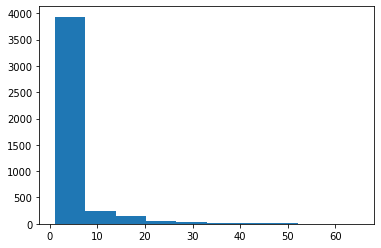

In [358]:
plt.hist(count_user_rating)

{'whiskers': [<matplotlib.lines.Line2D at 0x2be3a174948>,
 'caps': [<matplotlib.lines.Line2D at 0x2be3cc69e88>,
 'boxes': [<matplotlib.lines.Line2D at 0x2be3cc695c8>],
 'medians': [<matplotlib.lines.Line2D at 0x2be3cc79d08>],
 'fliers': [<matplotlib.lines.Line2D at 0x2be3cc79cc8>],
 'means': []}

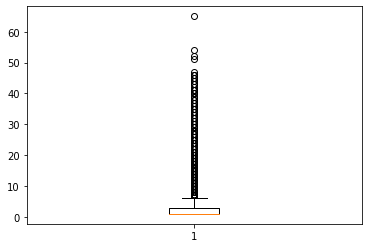

In [361]:
plt.boxplot(data = count_user_rating, x='user_rating_cnt')

In [21]:
ratings_min_6 = ratings.query('no_of_ratings >= 6')
ratings_min_6.head(3)

,rating_avg,no_of_ratings,over_80_ratio
title,,,
[강연형] 제국대학의 조센징,95.441767,498,0.945783
[공포괴담집] 무조건 모르는 척하세요,93.908629,197,0.949239
[공포괴담집] 저승에서 돌아온 남자,94.405286,227,0.964758


<div class="alert alert-warning">
근본적으로 우리가 책이 200권 정도밖에 없는데, <br>
리뷰 5개 이상인 책으로 바꾸면 그게 반토막 나게됨<br>
그렇게 데이터 수를 희생하면서 봐도 되는 것인지..?<br>
</div>

# Prediction With Surprise<a class="anchor" id="bullet3"></a>

## 분석 준비 및 연습

In [270]:
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold
from surprise import SVD
from surprise import NMF
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise.model_selection import cross_validate

In [447]:
all_review.sample()

,nickname,rating,title,voice,author,review,created,publish,genre,read_by
8793,Rosaparks,10.0,최민식이 읽는 이범선의 오발탄,최민식,이범선,좋네요,2018.12.31,커뮤니케이션북스,오디오북스,celeb


In [448]:
all_review['rating'].unique()

array([10.,  6.,  8.,  9.,  7.,  2.,  3.,  1.,  4.,  5.])

In [181]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(all_review[['nickname', 'title', 'new_rating']], reader)

In [450]:
# for algo in [SVD(), NMF(), KNNBasic(), KNNBaseline()]:
#     cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

<div class="alert alert-warning">
아래는 cosine similarity로 kNN 구하기<br>
안해도됨
</div>

In [ ]:
# sim_options = {'name': 'cosine',
#                'user_based': False  # compute  similarities between items
#                }
# algo = KNNBasic(sim_options=sim_options)
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.047612,0.605319,1.642606,0.143283
KNNBasic,1.090485,0.560712,0.990017,2.791874
NMF,3.120457,2.825224,2.614339,0.071487


<div class="alert alert-warning">
아래는 우리만의 알고리즘 만들떄 필요한거<br>
안해도됨
</div>

In [393]:
# from __future__ import (absolute_import, division, print_function,
#                         unicode_literals)
# import numpy as np
# from six import iteritems
# import heapq

# from surprise.prediction_algorithms.predictions import PredictionImpossible
# from surprise.prediction_algorithms.algo_base import AlgoBase

In [316]:
# kf = KFold(n_splits=3)

# algo = NMF() #이걸 SVD, KNNBasic으로 바꿔가며 결과 비교

# for trainset, testset in kf.split(data):
#     # train and test algorithm.
#     algo.fit(trainset)
#     predictions = algo.test(testset)

#     # Compute and print Root Mean Squared Error
#     accuracy.rmse(predictions, verbose=True)

RMSE: 76.8622
RMSE: 76.8241
RMSE: 76.8932


In [395]:
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

## 분석_POD

In [451]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(all_review[['nickname', 'title', 'rating']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
pod_SVD = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
pod_SVD

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.044225,0.605218,1.754307,0.096075
KNNBasic,1.094358,0.559481,1.157902,3.234350
NMF,3.030852,2.740114,3.140597,0.085107


## 분석_MDL

In [461]:
mydramalist = pd.read_csv('C:/Users/Hanna Kim/Desktop/drama_recommendation/reviews_to_top_40.csv', index_col = 0)

In [462]:
mydramalist.sample()

,title,reviewer,overall,story,acting,music,rewatch
26498,Familyhood,NoobieFan,8.0,8.0,7.5,8.0,8.0


In [463]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'overall']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_overall = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_overall

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.445626,1.041427,3.491996,0.351724
KNNBasic,1.643193,1.139554,0.422867,2.018601
NMF,2.572611,2.257866,5.302153,0.272935


In [464]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'story']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_story = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_story

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.499345,1.084395,4.176495,0.263630
KNNBasic,1.686498,1.173574,0.298202,1.556503
NMF,2.539696,2.212542,6.430136,0.158907


In [465]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'music']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_music = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_music

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.521209,1.114127,4.018252,0.553520
KNNBasic,1.835846,1.292237,0.404250,1.642275
NMF,2.564468,2.215694,7.228006,0.145272


In [466]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'acting']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_acting = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_acting

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.258419,0.882337,3.454425,0.428188
KNNBasic,1.409659,0.956341,0.428188,1.830104
NMF,2.789891,2.529618,5.230676,0.175862


In [467]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'rewatch']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_rewatch = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_rewatch

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,2.183483,1.633894,2.992994,0.203458
KNNBasic,2.524493,1.816171,0.319479,1.793542


In [194]:
mydramalist[mydramalist.isna().any(axis=1)]

,title,reviewer,overall,story,acting,music,rewatch


In [468]:
mydramalist['mean'] = (mydramalist.iloc[:, 2:]).apply(np.mean, axis=1)

In [469]:
mydramalist.sample()

,title,reviewer,overall,story,acting,music,rewatch,mean
15601,Castaway on the Moon,Jia M,9.0,9.0,10.0,8.0,10.0,9.2


In [470]:
mydramalist['mean'] = (mydramalist.iloc[:, 2:]).apply(np.mean, axis=1)
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'mean']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_mean = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_mean

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.358417,0.999815,2.775909,0.250330
KNNBasic,1.584936,1.135069,0.341752,1.690811


## 난 너무 화가 난다 POD vs. MDL

직관적으로는 팟빵 평점 데이터가 별로일 것 같은데, `

Text(0.5, 1.0, 'MyDramaList Ratings')

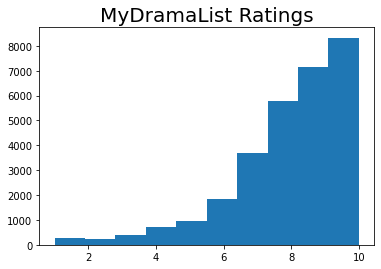

In [33]:
plt.hist(mydramalist['overall'], bins = 10)
plt.title("MyDramaList Ratings", fontsize = 20)

Text(0.5, 1.0, 'Podbbang Ratings')

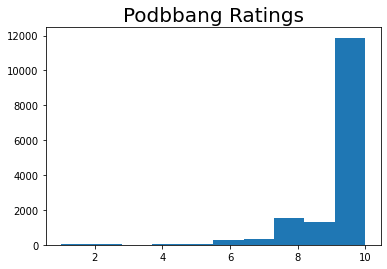

In [31]:
plt.hist(all_review['new_rating'], bins = 10)
plt.title("Podbbang Ratings", fontsize = 20)

## 개선해볼까

이럴거면 그냥 다 10점 주는 알고리즘 만들자

In [471]:
from surprise import AlgoBase
from surprise import Dataset
from surprise.model_selection import cross_validate


class all_10(AlgoBase):

    def __init__(self):

        # Always call base method before doing anything.
        AlgoBase.__init__(self)

    def estimate(self, u, i):

        return 10

all_10으로 팟빵 예측한 결과는

In [472]:
calc = []
# Perform cross validation
algorithm = all_10()
results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)

# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
calc.append(tmp)
    
pod_all_10 = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
pod_all_10

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
all_10,2.735204,2.098702,0.005983,0.094081


근데 그래도 pod_SVD가 예측 더 잘함...why

팟빵 데이터에도 10점이 아닌게 있으니 다 10점을 때려버리면 안될듯 <br>
그러면 전체 데이터의 평균(global mean)을 사용해서 예측한다면?

In [473]:
class GlobalMean(AlgoBase):

    def __init__(self):

        # Always call base method before doing anything.
        AlgoBase.__init__(self)

    def fit(self, trainset):

        # Here again: call base method before doing anything.
        AlgoBase.fit(self, trainset)

        # Compute the average rating. We might as well use the
        # trainset.global_mean attribute ;)
        self.the_mean = np.mean([r for (_, _, r) in
                                 self.trainset.all_ratings()])

        return self

    def estimate(self, u, i):

        return self.the_mean

In [474]:
data = Dataset.load_from_df(all_review[['nickname', 'title', 'rating']], reader)


calc = []
# Perform cross validation
algorithm = GlobalMean()
results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)

# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
calc.append(tmp)
    
pod_global_mean = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
pod_global_mean

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
GlobalMean,1.185976,0.785805,0.020607,0.072473


In [457]:
mydramalist.sample()

,title,reviewer,overall,story,acting,music,rewatch
3912,49 Days,BAsfaw,7.0,9.0,8.5,6.5,6.5


In [475]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'overall']], reader)


calc = []
# Perform cross validation
algorithm = GlobalMean()
results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)

# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
calc.append(tmp)
    
mdl_global_mean = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_global_mean

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
GlobalMean,1.830655,1.400377,0.031582,0.17021


In [476]:
a = pd.DataFrame(np.array([mdl_acting.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['mdl_acting_SVD'])

b = pd.DataFrame(np.array([mdl_story.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['mdl_story_SVD'])

c = pd.DataFrame(np.array([mdl_mean.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['mdl_mean_SVD'])

d = pd.DataFrame(np.array([pod_SVD.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['pod_SVD'])

e = pd.DataFrame(np.array([pod_all_10.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['pod_all_10'])

f = pd.DataFrame(np.array([pod_global_mean.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['pod_global_mean'])

g = pd.DataFrame(np.array([mdl_global_mean.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['mdl_global_mean'])

In [477]:
all_algo = pd.concat([a,b,c,d,e,f,g], axis = 0)
all_algo

,test_rmse,test_mae,fit_time,test_time
mdl_acting_SVD,1.258419,0.882337,3.454425,0.428188
mdl_story_SVD,1.499345,1.084395,4.176495,0.263630
mdl_mean_SVD,1.358417,0.999815,2.775909,0.250330
pod_SVD,1.044225,0.605218,1.754307,0.096075
pod_all_10,2.735204,2.098702,0.005983,0.094081
pod_global_mean,1.185976,0.785805,0.020607,0.072473
mdl_global_mean,1.830655,1.400377,0.031582,0.170210


In [478]:
all_algo.loc[['mdl_global_mean', 'mdl_acting_SVD']]

,test_rmse,test_mae,fit_time,test_time
mdl_global_mean,1.830655,1.400377,0.031582,0.170210
mdl_acting_SVD,1.258419,0.882337,3.454425,0.428188


In [479]:
all_algo.loc[['pod_global_mean', 'pod_SVD']]

,test_rmse,test_mae,fit_time,test_time
pod_global_mean,1.185976,0.785805,0.020607,0.072473
pod_SVD,1.044225,0.605218,1.754307,0.096075


mdl과 다르게 pod은 바보같아 보이는 global_mean을 적용하나 똑똑한 SVD를 적용하나 error의 차이가 크지 않아요.<br>
애초에 데이터가 10점에 몰려있으니 그게 그거겟죠? <br>
**그러면 우리는 팟빵의 오디오북 퀄리티가 높아서 이런 결과가 나왔다고 할 수 있을까?**<br>
### 놉

In [480]:
all_algo.iloc[6,0] - all_algo.iloc[6,0]

0.0

In [221]:
all_algo

,test_rmse,test_mae,fit_time,test_time
mdl_acting_SVD,1.260538,0.884254,3.702428,0.355718
mdl_story_SVD,1.499974,1.084920,2.927170,0.244683
mdl_mean_SVD,1.362060,1.000769,2.817463,0.176194
pod_SVD,1.047612,0.605319,1.642606,0.143283
pod_all_10,2.735595,2.098703,0.003991,0.085447
pod_global_mean,1.186410,0.786285,0.012964,0.043550
mdl_global_mean,1.830818,1.400521,0.018617,0.101727


# 2020-11-30의 시도들

## 데이터 정리

In [263]:
all_review.sample()

,nickname,rating,title,voice,author,review,created,publish,genre,read_by
15452,kwonjkim,9.0,까칠한 아이(성우 낭독 버전),"김하루,김유림,가빈,박민기",남찬숙,아주좋아요,2019.09.08,NaN,어린이동화,celeb


In [264]:
pivot_review = all_review.pivot_table(index= 'nickname', columns = 'title', values = 'rating')

In [265]:
#sparsity
print(f"데이터 sparsity : {1 - (pivot_review.count().sum() / (pivot_review.shape[0]*pivot_review.shape[1]))}")

데이터 sparsity : 0.9821065975223279


In [296]:
rate = all_review[['nickname', 'title', 'rating']]
rate.sample(3)

,nickname,title,rating
5252,방눌이,[공포괴담집] 저승에서 돌아온 남자,10.0
5568,별그리고별,[한예리 낭독] 안락 _ 작은책,10.0
11981,리틀축구감독,초등 감정 사용법,10.0


In [297]:
user_df = pd.DataFrame(list(rate.nickname	.unique()), columns = ['nickname'])
user_df['usr_id'] = random.sample(range(1,len(user_df)+1), len(user_df))

title_df = pd.DataFrame(list(rate.title.unique()), columns = ['title'])
title_df['ttl_id'] = random.sample(range(1,len(title_df)+1), len(title_df))

rate = rate.merge(user_df, how = 'left' )
rate = rate.merge(title_df, how = 'left' )
rate.columns = ['user', 'title', 'rating', 'usr_id', 'ttl_id']
rate.sample()

,user,title,rating,usr_id,ttl_id
8048,차군아커피,빨강머리 앤 : 초록지붕 집 이야기,9.0,910,83


## 예측하고 검증하기 (for heavy user)

In [377]:
heavy_user = list(review_count[review_count['rating'] >= 12].index)

In [423]:
rate.sample()

,user,title,rating,usr_id,ttl_id
963,꿈을먹는아이,좀머 씨 이야기,10.0,1854,172


In [426]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rate[['user', 'title', 'rating']], reader)

# Build an algorithm, and train it.
algo = SVD()

kf = KFold(n_splits=3)

for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
df.sample(3)

,uid,iid,rui,est,details,Iu,Ui,err
2875,bombi,"100인의 배우, 우리 문학을 읽다",10.0,8.207686,{'was_impossible': False},0,72,1.792314
4964,리버피닉스93,사기를 읽다,10.0,9.502224,{'was_impossible': False},1,119,0.497776
2449,마임,[청하 낭독] 환한 밤 (단편),9.0,9.472841,{'was_impossible': False},42,41,0.472841


In [442]:
from sklearn.metrics import mean_squared_error

In [445]:
y_true = df[df['uid'].isin(heavy_user)]['rui']
y_pred = df[df['uid'].isin(heavy_user)]['est']
RMSE = mean_squared_error(y_true, y_pred)**0.5
RMSE

0.8228289694122438